![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [168]:
# Run the cells below first

In [169]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import torch.nn.init as init

In [170]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [171]:
# Start coding here
# Use as many cells as you need

In [172]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32)

torch.Size([1, 28, 28])


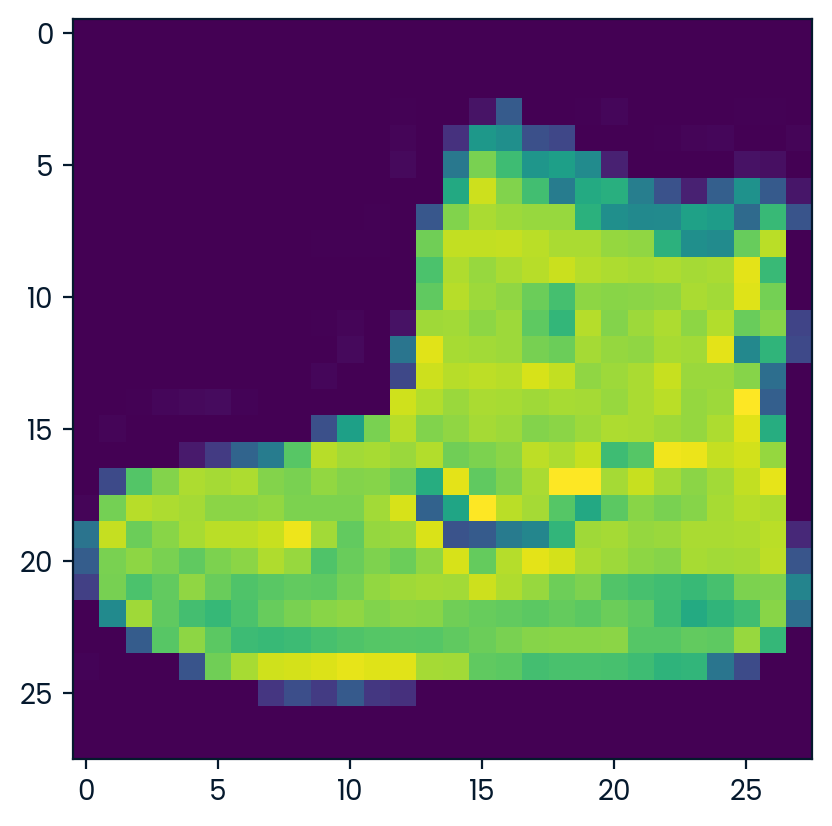

In [173]:
sample_batch = next(iter(train_data))
import matplotlib.pyplot as plt
# If your dataset returns (inputs, labels), unpack like this:
inputs, labels = sample_batch
print(inputs.size())
plt.imshow(inputs[0].squeeze(0))
plt.show()

In [174]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size =3, padding =1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= 2),
            nn.Conv2d(32, 64, kernel_size =3, padding =1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= 2),
            nn.Flatten()
    )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ELU(),

            nn.Linear(64, 10)
)
        init.kaiming_uniform_(self.classifier[0].weight)
        init.kaiming_uniform_(self.classifier[3].weight)
        init.kaiming_uniform_(self.classifier[6].weight)
    def forward(self, x):
        x =self.feature_extractor(x)
        x=self.classifier(x)
        return x

In [175]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-5)

In [176]:
net.train()  

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [177]:
import torchmetrics

accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
precision_metric = torchmetrics.Precision(task="multiclass", num_classes=10, average=None)
recall_metric = torchmetrics.Recall(task="multiclass", num_classes=10, average=None)


In [167]:
for epoch in range(2):
    net.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        pred = net(images)
        loss = criterion(pred,labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    accuracy_metric.reset()
    predictions = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = net(images)  # not net(images), assuming your instance is named model
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            accuracy_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)

# Compute the metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print('Accuracy:', accuracy)
print('Precision (per class):', precision)
print('Recall (per class):', recall)
